In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
fontsize = 20
from functools import partial, reduce
# compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.integrate import trapezoid as trapz
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import pynumdiff.optimize
import sys; sys.path.insert(0, "../derivative/"); import derivative
from derivative import dxdt as ddd

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize
from sklearn.utils.random import sample_without_replacement

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions
from para_UBIC import *
from mdl_comp import RidgeMDLCOMP

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

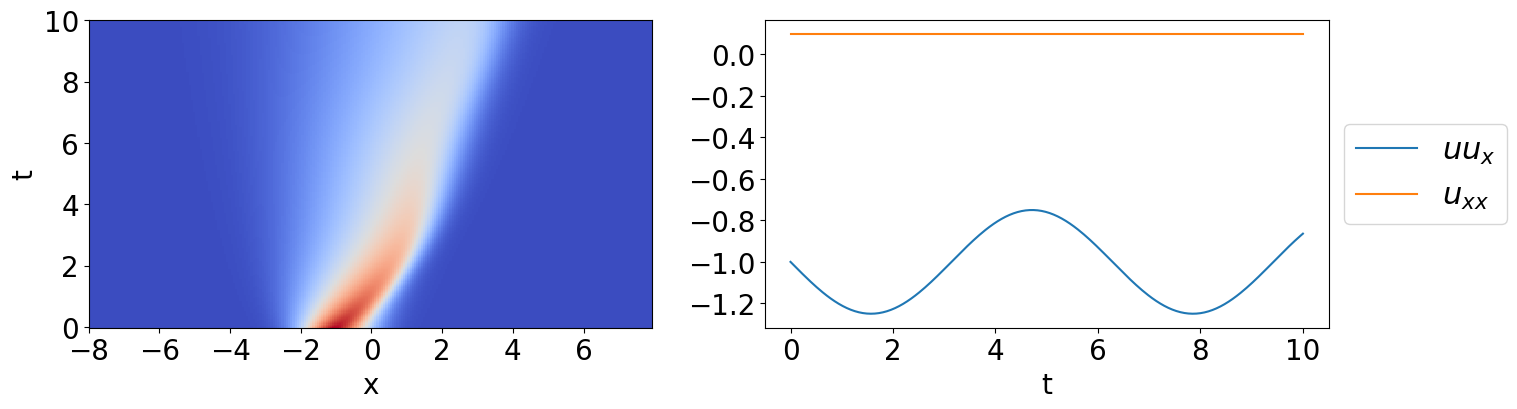

In [3]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
u_clean = u.copy()
u_clean_t = FinDiff(1, dt, 1, acc=4)(u_clean)
u_clean_x = FinDiff(0, dx, 1, acc=4)(u_clean)
u_clean_xx = FinDiff(0, dx, 1, acc=4)(u_clean_x)
u_clean_xxx = FinDiff(0, dx, 1, acc=4)(u_clean_xx)
u_clean_xxxx = FinDiff(0, dx, 1, acc=4)(u_clean_xxx)
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [5]:
include_bias = False
is_denoising = True

if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=1)

ttt = u.copy()
alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=include_bias, 
                                                                              dependent='temporal')

# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "temporal")

In [6]:
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

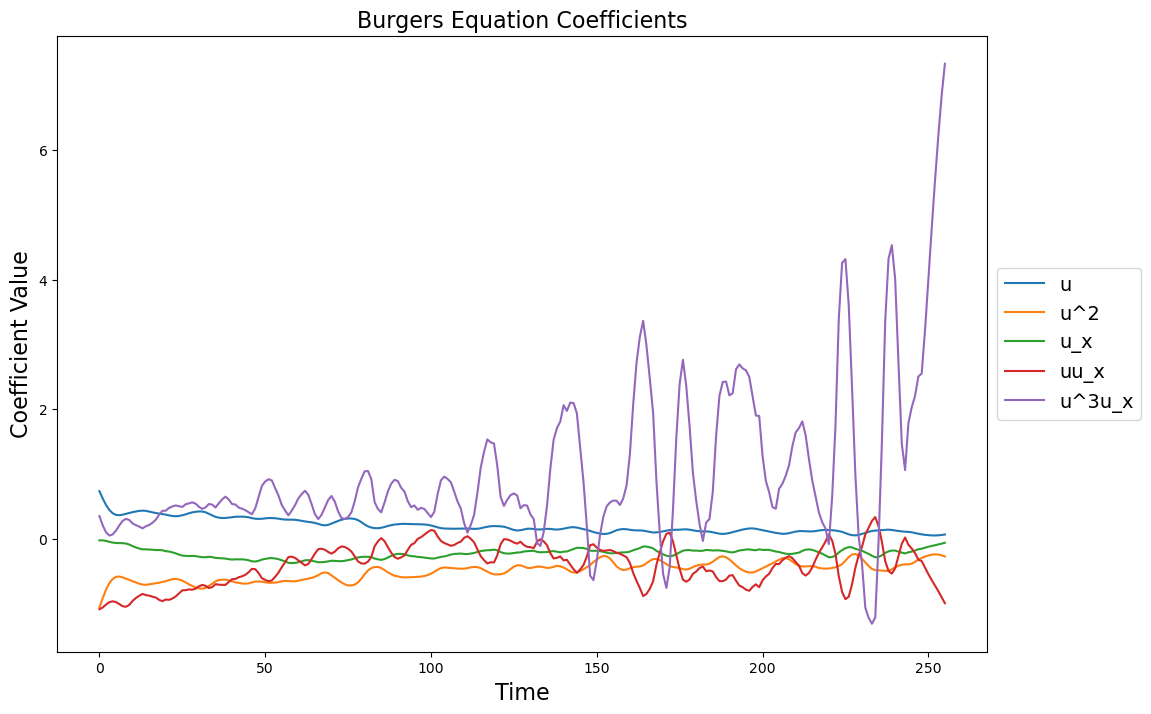

In [7]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [8]:
# 0.1821324868907128
# xi = xi[np.where(np.linalg.norm(xi, axis=-1))[0]]
xi = xi[[4, 7]]
errors = np.array([coeff_error(xi[0], u_xx_true), coeff_error(xi[1], uu_x_true)])
print(errors)
errors.mean(), errors.std()

[100.          61.20097159]


(80.60048579694273, 19.399514203057258)

In [9]:
candidates = set()
max_complexity = 10 # X_weak.shape[-1]

normalized_Theta_grouped, normalized_Ut_grouped = normalize_groups(Theta_grouped, 
                                                                   Ut_grouped, 
                                                                   2)

counter = {0}; i = 0
max_counter = 30
while True:
    bs_i = solvel0(normalized_Theta_grouped[i], 
                   normalized_Ut_grouped[i], 
                   max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
    bs_i = list(map(tuple, bs_i))
    candidates = candidates.union(bs_i)
    
    print(len(counter))
    if len(counter) == max_counter: break
        
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))
    counter.add(i)

candidates

Set parameter Username


2024-06-03 22:16:13,813 [INFO] Set parameter Username


2024-06-03 22:16:13,814 [INFO] 


--------------------------------------------


2024-06-03 22:16:13,816 [INFO] --------------------------------------------


2024-06-03 22:16:13,817 [INFO] Warning: your license will expire in 1 days


--------------------------------------------


2024-06-03 22:16:13,819 [INFO] --------------------------------------------


2024-06-03 22:16:13,820 [INFO] 


Academic license - for non-commercial use only - expires 2024-06-04


2024-06-03 22:16:13,823 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


{(0, 1, 2, 3),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 6, 7, 11, 13, 17),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 5),
 (0, 1, 2, 3, 5, 6, 7, 11),
 (0, 1, 2, 3, 5, 6, 7, 11, 15),
 (0, 1, 2, 3, 5, 6, 7, 11, 15, 17),
 (0, 1, 2, 3, 5, 7, 8),
 (0, 1, 2, 3, 5, 7, 8, 10, 11),
 (0, 1, 2, 3, 5, 7, 8, 10, 17),
 (0, 1, 2, 3, 5, 7, 10, 11),
 (0, 1, 2, 3, 5, 7, 10, 11, 15, 16),
 (0, 1, 2, 3, 5, 7, 11),
 (0, 1, 2, 3, 5, 7, 11, 18),
 (0, 1, 2, 3, 5, 9, 12),
 (0, 1, 2, 3, 5, 16),
 (0, 1, 2, 3, 6, 9, 14, 18),
 (0, 1, 2, 3, 7),
 (0, 1, 2, 3, 7, 8, 9, 11, 13, 14),
 (0, 1, 2, 3, 7, 8, 9, 11, 15),
 (0, 1, 2, 3, 7, 9, 11, 13, 15, 17),
 (0, 1, 2, 3, 7, 9, 11, 16),
 (0, 1, 2, 3, 7, 9, 16),
 (0, 1, 2, 3, 7, 9, 16, 17),
 (0, 1, 2, 3, 7, 10, 11, 15, 16, 17),
 (0, 1, 2, 3, 7, 11),
 (0, 1, 2, 3, 9),
 (0, 1, 2, 3, 9, 10),
 (0, 1, 2, 3, 9, 11),
 (0, 1, 2, 3, 9, 13),
 (0, 1, 2, 3, 9, 14, 18),
 (0, 1, 2, 3, 9, 15, 16),
 (0, 1, 2, 3, 10, 12),
 (0, 1, 2, 3, 15),
 (0, 1, 2, 3, 16),
 (0, 1, 2, 4, 6, 7, 8, 9, 12, 15),
 (0, 1, 

In [10]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        # est_xi = RidgeMDLCOMP().fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        # difference = Ut_grouped[j] - Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss

candidates = set([e[0] for e in list(track.values())])
### If using RidgeMDLCOMP ###
# {(0, 1, 2, 3, 4, 5, 7, 15, 18),
#  (0, 1, 2, 3, 4, 7, 11),
#  (0, 1, 2, 3, 7, 16),
#  (0, 1, 3, 4, 6, 7, 9, 12, 15, 17),
#  (0, 1, 3, 4, 7, 12, 15, 18),
#  (0, 2, 3, 4, 6, 7, 9, 10, 12, 15, 18),
#  (1, 2, 4, 7, 15),
#  (3,),
#  (4, 7),
#  (4, 7, 14),
#  (4, 7, 15, 17)}
candidates

lam: 0.0015713369095847675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.49it/s]


{(0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 5, 6, 7, 11, 15),
 (0, 1, 2, 3, 5, 7, 11, 18),
 (0, 1, 2, 3, 7, 10, 11, 15, 16, 17),
 (0, 1, 3, 4, 7),
 (1, 2, 4, 7),
 (3,),
 (4, 7),
 (4, 7, 8)}

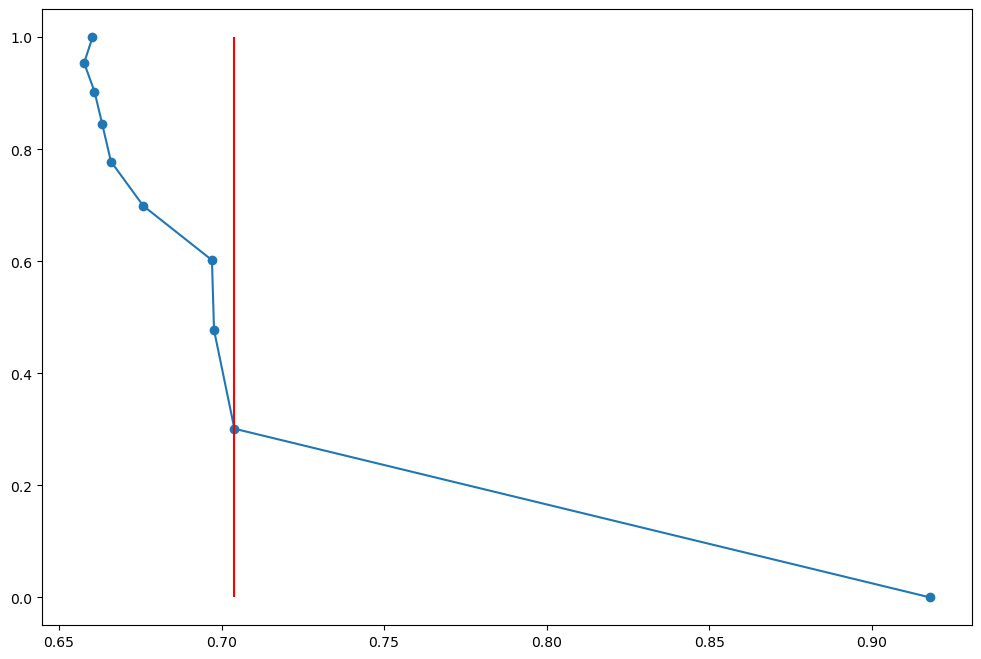

In [11]:
log_errors = []
log_coms = []
for indices in sorted(candidates, key=len):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.sum(difference**2)
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms), ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()

#### with time_integrator

aic: 7 2


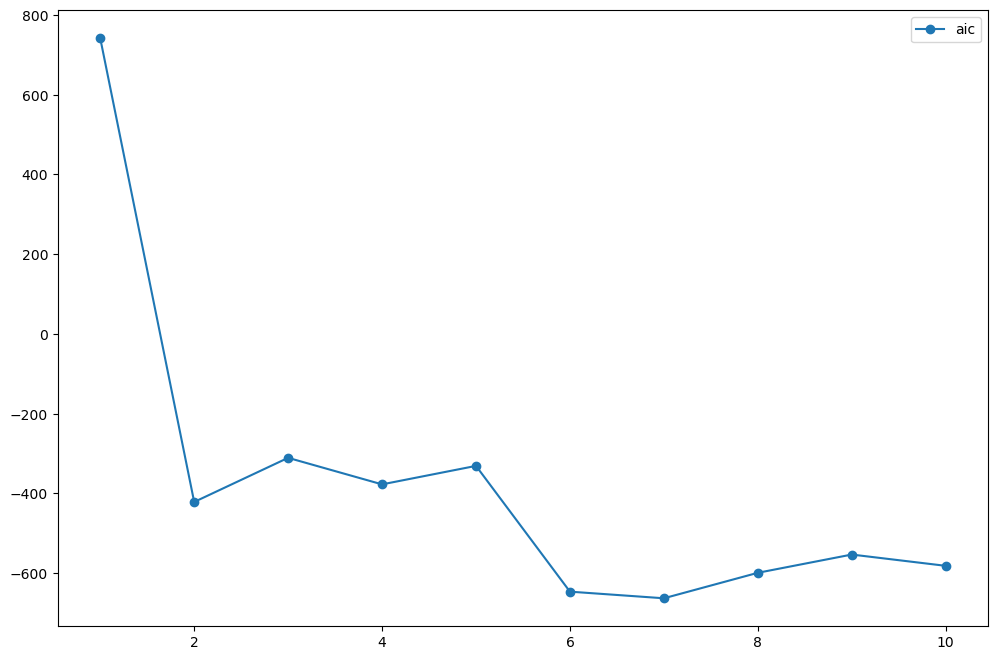

In [12]:
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
time_integrator = compose(time_integrator, 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        # est_xi[indices, j:j+1] = RidgeMDLCOMP().fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    
    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    k = len(np.where(np.linalg.norm(est_xi, axis=-1)>0)[0])
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+1e-5) + 2*k+(2*k**2+2*k)/(N-k-1)
    bic = N*np.log(2*np.pi*rss/N+1e-5) + np.log(N)*k
    
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print("aic:", complexities[np.argmin(aics)], find_corner(complexities, aics))
plt.plot(complexities, aics, '-o', label='aic')
plt.legend(); plt.show()

bic: 7 2


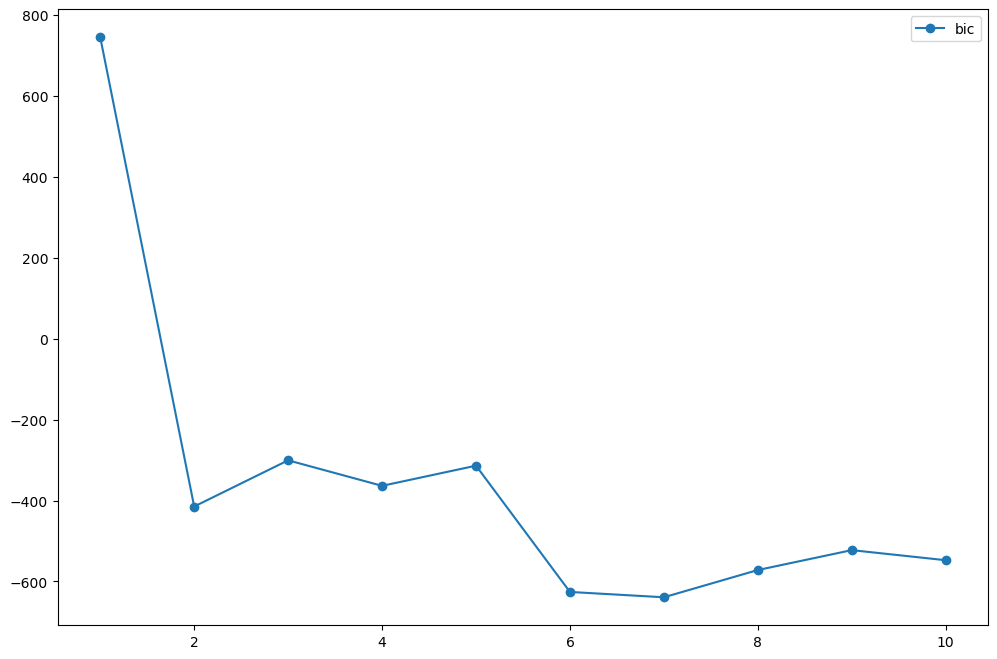

In [13]:
print("bic:", complexities[np.argmin(bics)], find_corner(complexities, bics))
plt.plot(complexities, bics, '-o', label='bic')
plt.legend(); plt.show()

In [14]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        post_prediction = (Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(Ut_grouped[j] - post_prediction, 'fro')**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 994.47it/s]


#### in PSD space

In [15]:
complexities = sorted(best_subsets.keys())

min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

nfft = max(fft_Ut_grouped[:, :, 0].shape)
nfft = None
# ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
ground_periogram = periodogram(Ut_grouped, axis=1, return_onesided=False)[1][:, :, 0]

Min, knee: 6 2


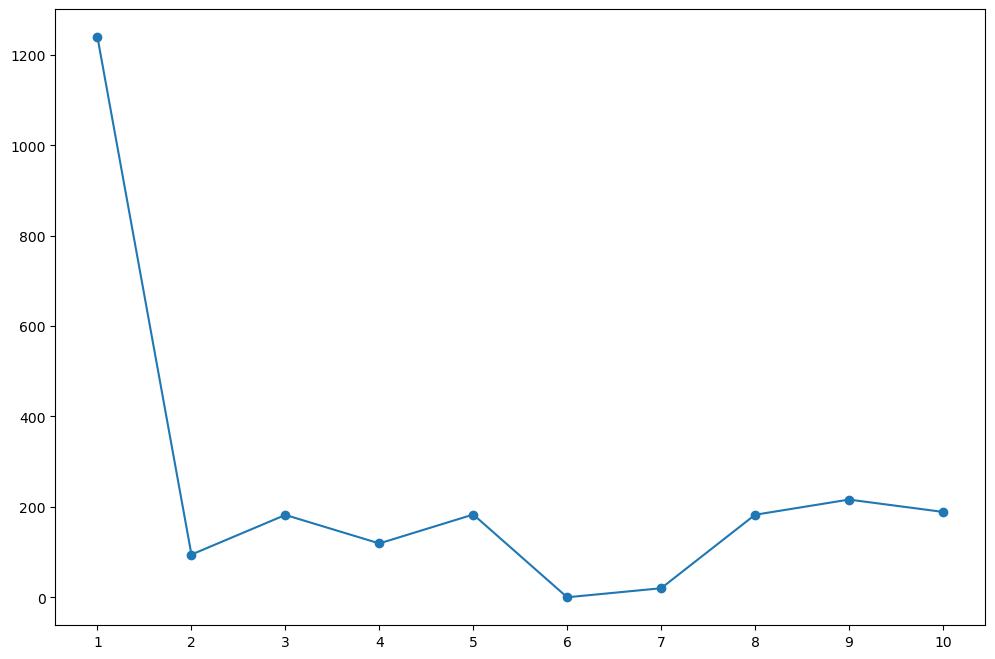

In [16]:
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
ics = []
rss_list = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        est_xi[eff_indices, j:j+1] = ARDRegression(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
    
        # post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        # post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        # ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=False)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=False)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
        
    # pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    # pred_periogram = periodogram(pred_group, nfft=nfft)[-1]
    pred_group = prediction_group(Theta_grouped, est_xi)
    pred_periogram = periodogram(pred_group, axis=1, return_onesided=False)[1]
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(diff_periogram))])
    nobs = np.prod(diff_periogram.shape)
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)
    
print("Min, knee:", np.argmin(ics)+1, find_corner(complexities, ics))
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

#### Verification process

In [17]:
varying_bics = []
pvalues = [0.0]
for eff_indices in sorted(candidates, key=len):
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    com = len(eff_indices)
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = ARDRegression(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
                                                     Ut_grouped[j], 
                                                     rcond=None)[0]
#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=False)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=False)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    pvalue = np.nan
    if len(varying_bics) > 0 and not np.allclose(vbics, varying_bics[-1]):
        # wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        wres = mannwhitneyu(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
        
    print(eff_indices, pvalue)

varying_bics = np.array(varying_bics)
varying_bics = varying_bics-varying_bics.min()
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
varying_bics = varying_bics[:, sample_without_replacement(varying_bics.shape[1], 
                                                          varying_bics.shape[1])]

valid_indices = []
min_bic = np.inf
j = None
pcut = 0.01
pvalues = np.array(pvalues)
# pcut = np.percentile(pvalues[(0 < pvalues) & (pvalues < pcut)], 90); print(pcut)
pcut = np.median(pvalues[(0 < pvalues) & (pvalues < pcut)]); print(pcut)
for i, pvalue in enumerate(pvalues):
    if ics[i] < min_bic:
        min_bic = ics[i]
        if i == 0: 
            pvalue = 0.0
        else: 
            # pvalue = wilcoxon(varying_bics[i], varying_bics[j], alternative='less').pvalue
            pvalue = mannwhitneyu(varying_bics[i], varying_bics[j], alternative='less').pvalue
            print(pvalue)
        if pvalue < pcut:
            valid_indices.append(i)
        j = i
valid_indices

(3,) nan
(4, 7) 2.960176286863486e-21
(4, 7, 8) 0.8364804066718142
(1, 2, 4, 7) 0.17313238451023816
(0, 1, 3, 4, 7) 0.6465736936980497
(0, 1, 2, 3, 4, 7) 0.0005376036791898074
(0, 1, 2, 3, 4, 6, 7) 0.10185599867585332
(0, 1, 2, 3, 5, 7, 11, 18) 0.7600517453397232
(0, 1, 2, 3, 5, 6, 7, 11, 15) 0.3792766039623229
(0, 1, 2, 3, 7, 10, 11, 15, 16, 17) 0.30463800136895103
0.0002688018395949037
2.960176286863486e-21
0.0006175680034645858


[0, 1]

#### With tuned UBIC

In [18]:
def conditional_argmin(ics, valid_indices=None):
    if valid_indices is None:
        return np.argmin(ics)
    else:
        assert len(valid_indices) > 0
        assert len(set(valid_indices)-set(np.arange(len(ics)))) == 0
        return max(valid_indices[np.where(valid_indices<=np.argmin(ics))[0]])
valid_indices = np.array(valid_indices) # None
    
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
assert np.allclose(np.array(ics), np.array(b_bics))
print(find_corner(complexities, b_bics))
    
idx2lambda =  d = dict([(_-1, []) for _ in complexities])
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
# last_bc = np.argmin(last_ubic)
last_bc = conditional_argmin(last_ubic, valid_indices)
idx2lambda[np.argmin(last_ubic)].append(last_lam)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = conditional_argmin(now_ubic, valid_indices)
    idx2lambda[np.argmin(now_ubic)].append(now_lam)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = varying_bics[now_bc]-varying_bics[last_bc]
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_adj = now_bc-adj_bc
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    if not np.allclose(diff_vbic, 0.0):
        # pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        # pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
        pvalue_pos = mannwhitneyu(varying_bics[now_bc], varying_bics[last_bc], alternative='less').pvalue
        pvalue_neg = mannwhitneyu(varying_bics[last_bc], varying_bics[now_bc], alternative='less').pvalue
    if np.abs(diff_adj) > 0:
        # pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue
        pvalue_adj = mannwhitneyu(varying_bics[now_bc], varying_bics[adj_bc], alternative='less').pvalue

    ### new version using wilcoxon or mannwhitneyu test ###
#     if verbose:
#         print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
#               np.nan_to_num(pvalue_pos, nan=np.inf), 
#               np.nan_to_num(pvalue_neg, nan=np.inf), 
#               np.nan_to_num(pvalue_adj, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
#         (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
#         break

    ### old version using threshold ###
    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
lam_plot = min(idx2lambda[last_bc])
ubic_plot = UBIC(b_bics, uncertainties, nobs, hyp=10**lam_plot)
lam_plot, last_lam, last_ubic, last_bc

2
1 ---> 1 inf
1 ---> 1 inf
1 ---> 1 inf
(4, 7) selected


(0.69179144,
 0.0,
 array([ 751.50329295, -393.59264214, -302.98412249, -365.11593554,
        -283.50557647, -459.31516039, -440.73168205, -276.9828417 ,
        -237.64958125, -263.3582972 ]),
 1)

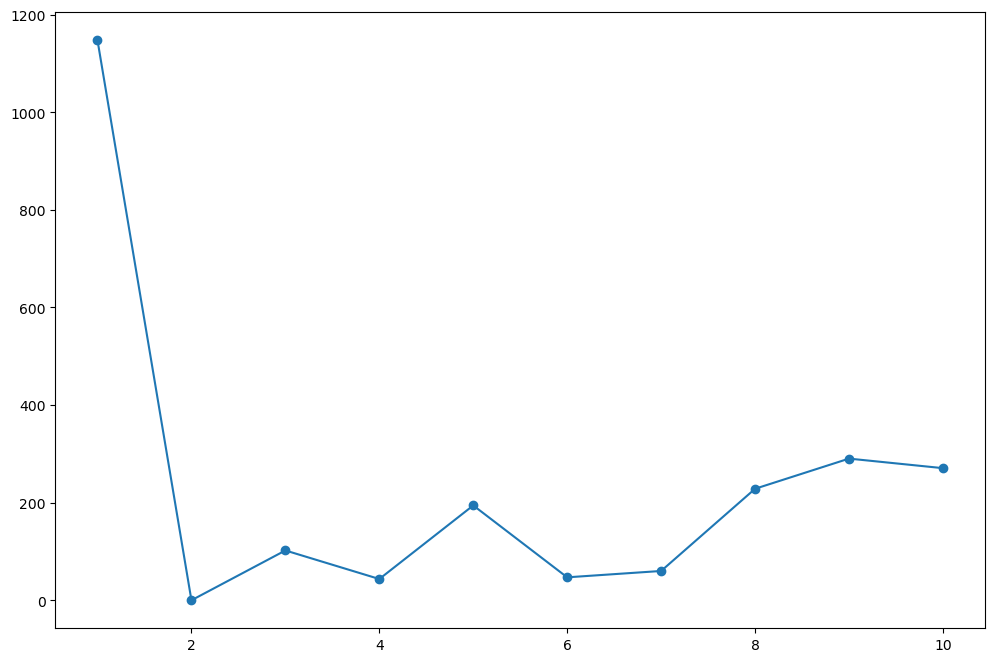

In [19]:
plt.plot(complexities, ubic_plot-min(ubic_plot), '-o'); plt.show()

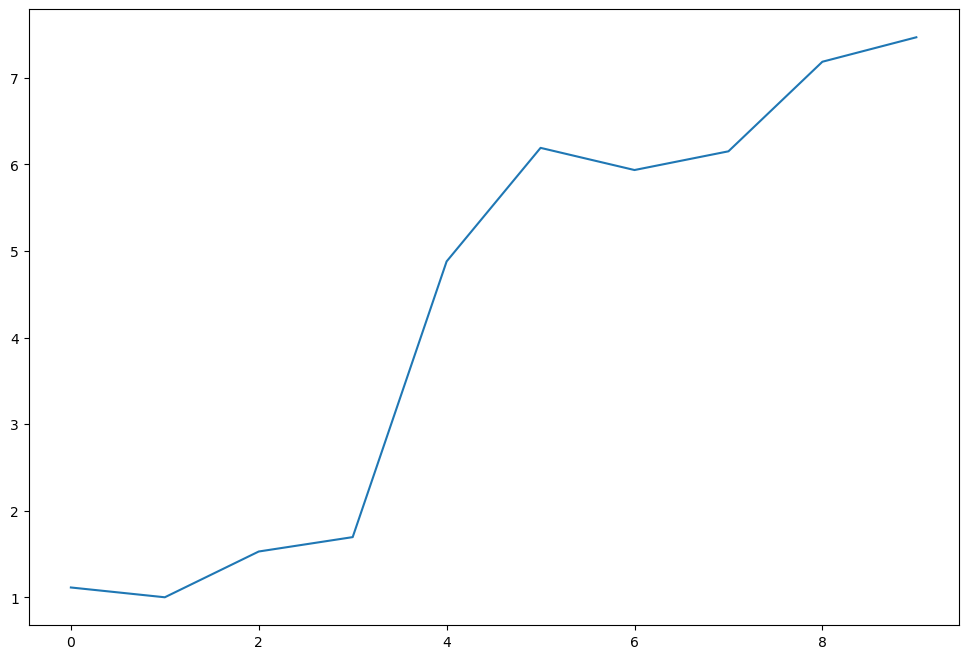

In [20]:
plt.plot(uncertainties); plt.show()

#### PLOT

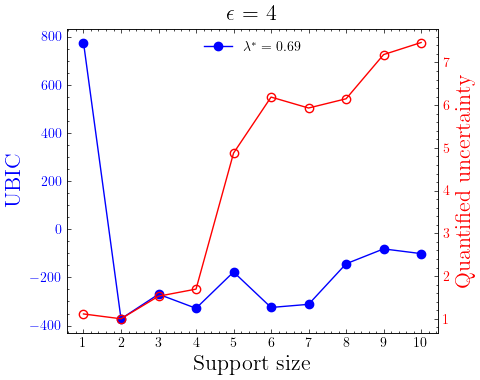

In [21]:
fs = 16
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(5, 4))

    color = 'blue'
    ax.set_xlabel('Support size', fontsize=fs)
    ax.set_ylabel('UBIC', color=color, fontsize=fs)
    ax.plot(complexities, ubic_plot, '-o', color=color, label='$\lambda^{*} = $' + ' ' + str(abs(round(lam_plot, 2))))
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xticks(complexities)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)

    axp = ax.twinx()
    color = 'red'
    axp.set_ylabel('Quantified uncertainty', color=color, fontsize=fs)
    axp.plot(complexities, uncertainties, '-o', color=color, markerfacecolor="None")
    axp.tick_params(axis='y', labelcolor=color)
    
    ax.legend(loc='upper center')
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/burgers_ubic_noise{noise_lv}.pdf")
    plt.show()

In [ ]:
# Computational time
# CPU times: user 12.1 s, sys: 29.4 ms, total: 12.1 s
# Wall time: 12.1 s